In [1]:
# import system libs
import os
import itertools

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import KFold

from zoopt import Dimension, Objective, Parameter, Opt


# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3

2024-09-25 15:52:21.175181: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-25 15:52:21.248187: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-25 15:52:21.280455: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-25 15:52:21.289790: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-25 15:52:21.339192: I tensorflow/core/platform/cpu_feature_guar

In [2]:
print(tf.__version__)

2.17.0


In [3]:
# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# loading the dataset
def loading_the_data(data_dir):
    # Generate data paths with labels
    filepaths = []
    labels = []

    # Get folder names
    folds = os.listdir(data_dir)

    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            
            filepaths.append(fpath)
            labels.append(fold)

    # Concatenate data paths with labels into one DataFrame
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')

    df = pd.concat([Fseries, Lseries], axis=1)
    
    return df

In [5]:
# change label names to its original names
def change_label_names(df, column_name):
    index = {'milddemented': 'Alzheimer MildDemented', 'Alzheimer NonDemented': 'Alzheimer_Nondemented', 'very_milddemented': 'Alzheimer VeryMildDemented'}


    df[column_name] = df[column_name].replace(index)

In [6]:
# loading the data
data_dir = '/home/idrone2/Desktop/alzheimer'
df = loading_the_data(data_dir)

change_label_names(df, 'labels')

df

,filepaths,labels
0,/home/idrone2/Desktop/alzheimer/Alzheimer NonD...,Alzheimer_Nondemented
1,/home/idrone2/Desktop/alzheimer/Alzheimer NonD...,Alzheimer_Nondemented
2,/home/idrone2/Desktop/alzheimer/Alzheimer NonD...,Alzheimer_Nondemented
3,/home/idrone2/Desktop/alzheimer/Alzheimer NonD...,Alzheimer_Nondemented
4,/home/idrone2/Desktop/alzheimer/Alzheimer NonD...,Alzheimer_Nondemented
...,...,...
5064,/home/idrone2/Desktop/alzheimer/Alzheimer Mild...,Alzheimer MildDemented
5065,/home/idrone2/Desktop/alzheimer/Alzheimer Mild...,Alzheimer MildDemented
5066,/home/idrone2/Desktop/alzheimer/Alzheimer Mild...,Alzheimer MildDemented
5067,/home/idrone2/Desktop/alzheimer/Alzheimer Mild...,Alzheimer MildDemented


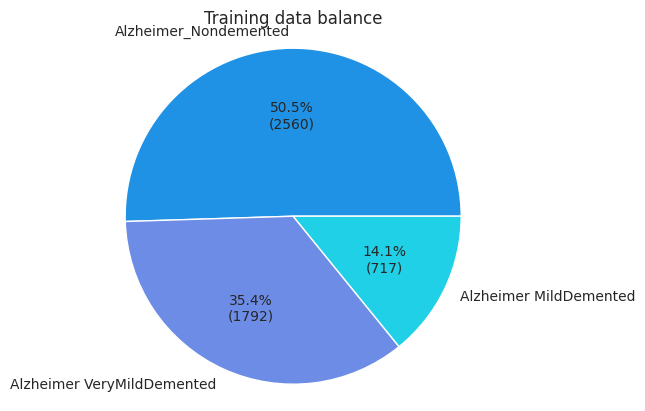

In [7]:
data_balance = df.labels.value_counts()


def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)


# pie chart for data balance
plt.pie(data_balance, labels = data_balance.index, autopct=custom_autopct, colors = ["#2092E6","#6D8CE6","#20D0E6"])
plt.title("Training data balance")
plt.axis("equal")
plt.show()

In [8]:
#spliting the data 
# data --> 80% train data && 20% (test, val)
#train_df, ts_df = train_test_split(df, train_size = 0.8, shuffle = True, random_state = 42)

# test data --> 10% train data && 10% (test, val)
#valid_df, test_df = train_test_split(ts_df, train_size = 0.5, shuffle = True, random_state = 42)

In [9]:
#kfold cross validation
k = 5

kf = KFold(n_splits=k, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(kf.split(df)):
    train_df = df.iloc[train_index]
    test_df = df.iloc[test_index]


    train_df, temp_df = train_test_split(df, train_size=0.8, random_state=42)
    valid_df, test_df = train_test_split(temp_df, train_size=0.5, random_state=42)


In [10]:
# create data generators
batch_size = 32
img_size = (224, 224)

tr_gen = ImageDataGenerator(rescale=1. / 255)
ts_gen = ImageDataGenerator(rescale=1. / 255)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 4055 validated image filenames belonging to 3 classes.
Found 507 validated image filenames belonging to 3 classes.
Found 507 validated image filenames belonging to 3 classes.


ValueError: num must be an integer with 1 <= num <= 3, not 4

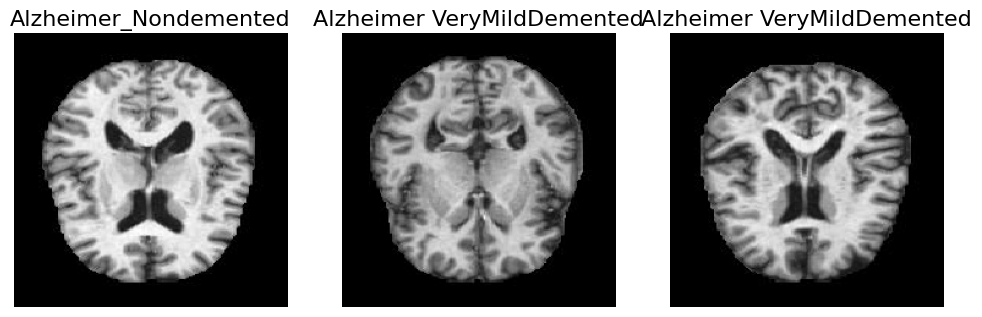

In [13]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

# ploting the patch size samples
plt.figure(figsize= (12, 8))

for i in range(batch_size):
    plt.subplot(1, 3, i + 1)
    image = images[i]
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'black', fontsize= 16)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [14]:
# Displaying the model performance
def model_performance(history, Epochs):
    # Define needed variables
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    
    Epochs = [i+1 for i in range(len(tr_acc))]
    
    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout
    plt.show()

In [15]:
# Evaluate the model
def model_evaluation(model):
    train_score = model.evaluate(train_gen, verbose= 1)
    valid_score = model.evaluate(valid_gen, verbose= 1)
    test_score = model.evaluate(test_gen, verbose= 1)
    
    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])

In [16]:
# Get Predictions
def get_pred(model, test_gen):
    
    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis = 1)
    
    return y_pred

In [17]:
# Confusion Matrix
def plot_confusion_matrix(test_gen, y_pred, fold):
    
    g_dict = test_gen.class_indices
    classes = list(g_dict.keys())
    
    # Display the confusion matrix
    cm = confusion_matrix(test_gen.classes, y_pred)

    plt.figure(figsize= (8, 8))
    plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Pinks)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    plt.show()

In [18]:
# Defining a convolutional NN block for a sequential CNN model
def conv_block(filters, act='relu'):
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPooling2D())
    
    return block

In [19]:
# Defining a dense NN block for a sequential CNN model
def dense_block(units, dropout_rate, act='relu'):
    
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

In [20]:
# # create Model structure
# img_size = (224, 224)
# channels = 3
# img_shape = (img_size[0], img_size[1], channels)

# class_counts = len(list(train_gen.class_indices.keys()))     # to define number of classes in dense layer

In [21]:
# Define the function to create the CNN model
def create_cnn_model(filters1, filters2, filters3, units1, units2, learning_rate):
    img_size = (224, 224)
    channels = 3
    img_shape = (img_size[0], img_size[1], channels)
    class_counts = len(list(train_gen.class_indices.keys()))

    cnn_model = Sequential()
    # First conv block
    cnn_model.add(Conv2D(filters=int(filters1), kernel_size=(3, 3), padding="same", activation="relu", input_shape=img_shape))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPooling2D())

    # Second conv block
    cnn_model.add(Conv2D(filters=int(filters2), kernel_size=(3, 3), padding="same", activation="relu"))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPooling2D())
def create_cnn_model(filters1, filters2, filters3, units1, units2, learning_rate, loss):
    inputs = keras.Input(shape=(128, 128, 3))  # Define input shape using an Input layer
    x = keras.layers.Conv2D(filters=filters1, kernel_size=(3, 3), activation='relu')(inputs)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = keras.layers.Conv2D(filters=filters2, kernel_size=(3, 3), activation='relu')(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = keras.layers.Conv2D(filters=filters3, kernel_size=(3, 3), activation='relu')(x)
    x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(units1, activation='relu')(x)
    x = keras.layers.Dense(units2, activation='relu')(x)
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)  # Create the model with defined inputs and outputs
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss=loss,
                  metrics=['accuracy'])
    return model
    # Third conv block
    cnn_model.add(Conv2D(filters=int(filters3), kernel_size=(3, 3), padding="same", activation="relu"))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPooling2D())

    # Flatten layer
    cnn_model.add(Flatten())

    # First dense block
    cnn_model.add(Dense(units=int(units1), activation='relu'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Dropout(0.5))

    # Second dense block
    cnn_model.add(Dense(units=int(units2), activation='relu'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Dropout(0.3))

    # Output layer
    cnn_model.add(Dense(class_counts, activation="softmax"))

    optimizer = Adam(learning_rate=learning_rate)
    cnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return cnn_model


In [23]:
best_model = create_cnn_model.summary() 

AttributeError: 'function' object has no attribute 'summary'

In [ ]:
def objective_function(solution):
    filters1, filters2, filters3, units1, units2, learning_rate = solution.get_x()
    kf = KFold(n_splits=3, shuffle=True, random_state=42)  # Reduce KFold for faster computation
    
    accuracies = []
    for train_index, val_index in kf.split(df):
        train_df = df.iloc[train_index]
        val_df = df.iloc[val_index]
        
        train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                               color_mode='rgb', shuffle=True, batch_size=batch_size)
        
        val_gen = ts_gen.flow_from_dataframe(val_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                             color_mode='rgb', shuffle=True, batch_size=batch_size)

        model = create_cnn_model(filters1, filters2, filters3, units1, units2, learning_rate)
        
        history = model.fit(train_gen, validation_data=val_gen, epochs=5, verbose=0)  # Reduce epochs for faster computation
        
        val_loss, val_acc = model.evaluate(val_gen, verbose=0)
        accuracies.append(val_acc)
    
    return -np.mean(accuracies) 

In [ ]:
dim = Dimension(
    6, 
    [
        [16, 64],
        [32, 128],
        [64, 256],
        [64, 512],
        [32, 256],
        [1e-5, 1e-3]
    ],
    [False, False, False, False, False, True]
)

# Define the objective for ZOOpt
obj = Objective(objective_function, dim)

# Optimization parameters
param = Parameter(budget=20)

# Perform optimization
solution = Opt.min(obj, param)

# Get the best hyperparameters
best_hyperparams = solution.get_x()

print(f"Best hyperparameters: {best_hyperparams}")

# Create and train the best model
best_model = create_cnn_model(*best_hyperparams)

# Dummy train and validation generators for this example
train_gen = ImageDataGenerator().flow_from_directory('/mnt/data', target_size=(224, 224), batch_size=32, class_mode='categorical')
valid_gen = ImageDataGenerator().flow_from_directory('/mnt/data', target_size=(224, 224), batch_size=32, class_mode='categorical')

history = best_model.fit(train_gen, validation_data=valid_gen, epochs=20, verbose=1)


In [26]:
# def objective_function(solution):
#     filters1, filters2, filters3, units1, units2, learning_rate = solution
#     kf = KFold(n_splits=3, shuffle=True, random_state=42)  # Reduce KFold for faster computation
    
#     accuracies = []
#     for train_index, val_index in kf.split(df):
#         train_df = df.iloc[train_index]
#         val_df = df.iloc[val_index]
        
#         train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
#                                                color_mode='rgb', shuffle=True, batch_size=batch_size)
        
#         val_gen = ts_gen.flow_from_dataframe(val_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
#                                              color_mode='rgb', shuffle=True, batch_size=batch_size)

#         model = create_cnn_model(filters1, filters2, filters3, units1, units2, learning_rate)
        
#         history = model.fit(train_gen, validation_data=val_gen, epochs=5, verbose=0)  # Reduce epochs for faster computation
        
#         val_loss, val_acc = model.evaluate(val_gen, verbose=0)
#         accuracies.append(val_acc)
    
#     return -np.mean(accuracies) 

In [27]:
# #difne the parameter for zoopt

# dim = Dimension(
#     6, 
#     [
#         [16, 64],
#         [32, 128],
#         [64, 256],
#         [64, 512],
#         [32, 256],
#         [1e-5, 1e-3]
#     ],
#     [False, False, False, False, False, True]
# )

In [28]:
# #difine the objective
# obj = Objective(objective_function, dim)

# #optimization parameter
# param = Parameter(budget= 20)

# #peformance optim..
# solution = Opt.min(obj, param)
# print(solution)

# #get best sol..
# best_hyperparams = solution.get_x()

# print(f"Best hyperparameters: {best_hyperparams}")



# best_model = create_cnn_model(*best_hyperparams)

# history = best_model.fit(train_gen, validation_data= valid_gen, epoch= 20, verbose = 1)
# model_performance(history, 20)
# model_evaluation(best_model)

In [29]:

# Define the objective function
def objective_function(solution):
    filters1, filters2, units1, learning_rate = solution.get_x()
    kf = KFold(n_splits=3, shuffle=True, random_state=42)  # Reduce KFold for faster computation
    
    accuracies = []
    for train_index, val_index in kf.split(df):
        train_df = df.iloc[train_index]
        val_df = df.iloc[val_index]
        
        train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                               color_mode='rgb', shuffle=True, batch_size=batch_size)
        
        val_gen = ts_gen.flow_from_dataframe(val_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                             color_mode='rgb', shuffle=True, batch_size=batch_size)

        model = create_cnn_model(filters1, filters2, units1, learning_rate)
        
        history = model.fit(train_gen, validation_data=val_gen, epochs=5, verbose=0)  # Reduce epochs for faster computation
        
        val_loss, val_acc = model.evaluate(val_gen, verbose=0)
        accuracies.append(val_acc)
    
    return -np.mean(accuracies) 

# Define the parameter space for ZOOpt
dim = Dimension(
    4, 
    [
        [16, 64],
        [32, 128],
        [64, 256],
        [0.1, 1e-3]
    ],
    [False, False, False, True]
)

# Define the objective for ZOOpt
obj = Objective(objective_function, dim)

# Optimization parameters
param = Parameter(budget=20)

# Perform optimization
solution = Opt.min(obj, param)

# Get the best hyperparameters
best_hyperparams = solution.get_x()

print(f"Best hyperparameters: {best_hyperparams}")

# Create and train the best model
best_model = create_cnn_model(*best_hyperparams)

history = best_model.fit(train_gen, validation_data=valid_gen, epochs=20, verbose=1)

# Evaluate the model performance
model_performance(history, 20)
model_evaluation(best_model)

Found 3379 validated image filenames belonging to 3 classes.
Found 1690 validated image filenames belonging to 3 classes.


I0000 00:00:1725443495.025812    8811 service.cc:146] XLA service 0xdcc38c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725443495.025834    8811 service.cc:154]   StreamExecutor device (0): NVIDIA RTX A2000 12GB, Compute Capability 8.6
2024-09-04 15:21:35.056266: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-04 15:21:35.181792: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902
I0000 00:00:1725443502.990891    8811 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Found 3379 validated image filenames belonging to 3 classes.
Found 1690 validated image filenames belonging to 3 classes.
Found 3380 validated image filenames belonging to 3 classes.
Found 1689 validated image filenames belonging to 3 classes.
Found 3379 validated image filenames belonging to 3 classes.
Found 1690 validated image filenames belonging to 3 classes.
Found 3379 validated image filenames belonging to 3 classes.
Found 1690 validated image filenames belonging to 3 classes.
Found 3380 validated image filenames belonging to 3 classes.
Found 1689 validated image filenames belonging to 3 classes.
Found 3379 validated image filenames belonging to 3 classes.
Found 1690 validated image filenames belonging to 3 classes.
Found 3379 validated image filenames belonging to 3 classes.
Found 1690 validated image filenames belonging to 3 classes.
Found 3380 validated image filenames belonging to 3 classes.
Found 1689 validated image filenames belonging to 3 classes.
Found 3379 validated ima

KeyboardInterrupt: 

In [ ]:
# optimizer = Adam(learning_rate = learning_rate)

In [ ]:
# cnn_model.compile(optimizer=optimizer, loss= 'categorical_crossentropy', metrics= ['accuracy'])


In [ ]:
# # train the model
# epochs = 30   # number of all epochs in training

# history = cnn_model.fit(train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 46s 276ms/step - accuracy: 0.6154 - loss: 0.9379 - val_accuracy: 0.4315 - val_loss: 2.0339
Epoch 2/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 51s 307ms/step - accuracy: 0.7343 - loss: 0.6462 - val_accuracy: 0.4247 - val_loss: 1.4555
Epoch 3/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 51s 307ms/step - accuracy: 0.7622 - loss: 0.5957 - val_accuracy: 0.4110 - val_loss: 1.4698
Epoch 4/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 51s 308ms/step - accuracy: 0.7766 - loss: 0.5397 - val_accuracy: 0.6575 - val_loss: 0.8321
Epoch 5/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 51s 308ms/step - accuracy: 0.7988 - loss: 0.4813 - val_accuracy: 0.8151 - val_loss: 0.4797
Epoch 6/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 51s 309ms/step - accuracy: 0.7990 - loss: 0.4832 - val_accuracy: 0.8014 - val_loss: 0.4885
Epoch 7/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 51s 308ms/step - accuracy: 0.8191 - loss: 0.4527 - val_accuracy: 0.8048 - val_loss: 0.4506
Epoch 8/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 51s 309ms/step - accuracy: 0.8328 - loss: 0

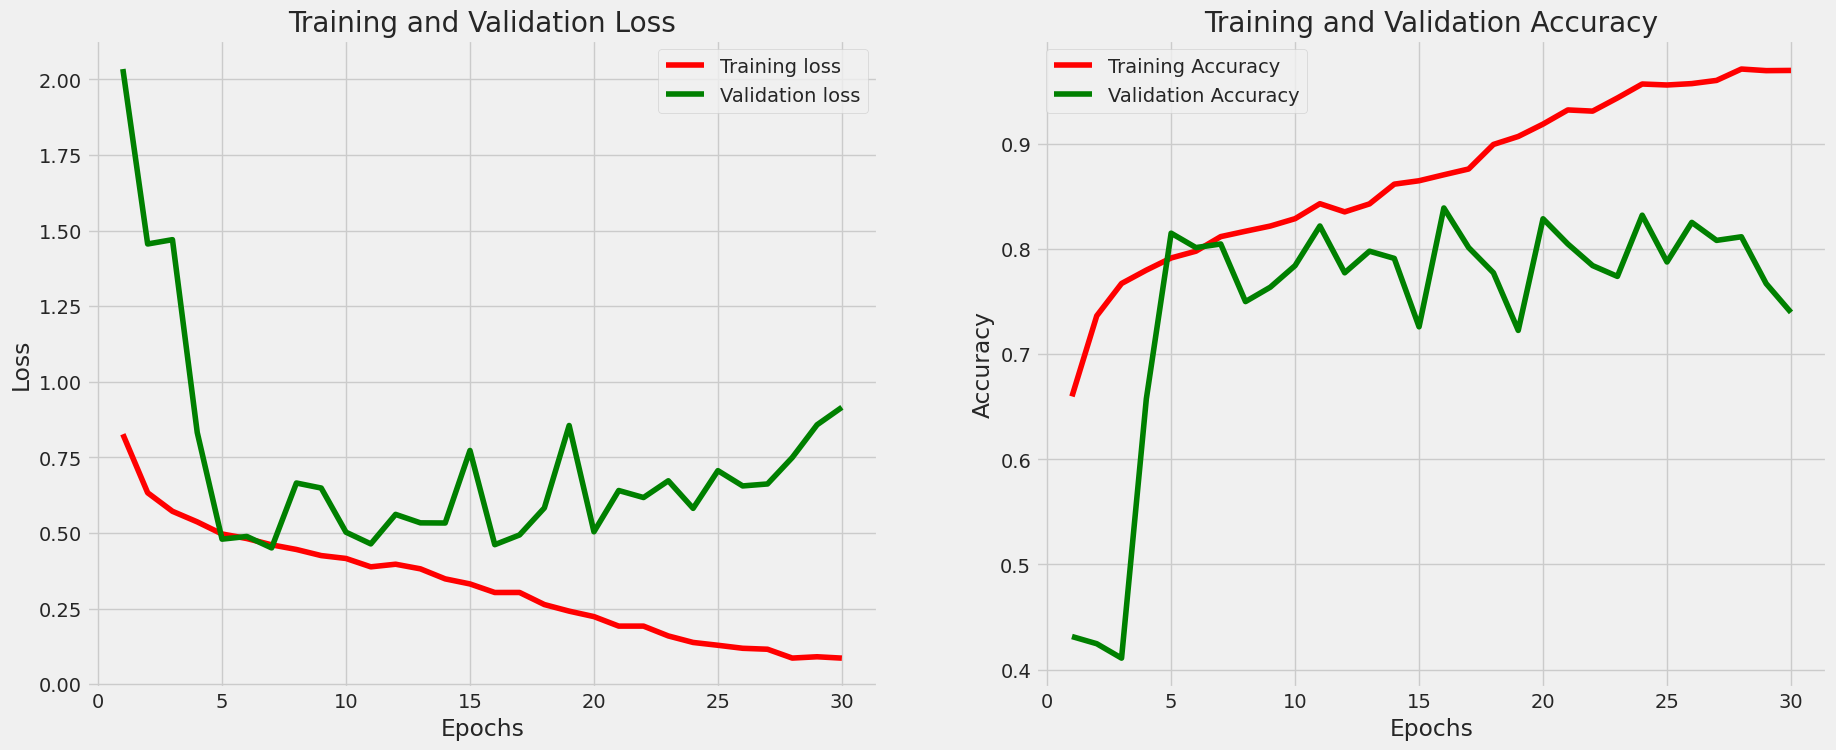

In [ ]:
# Display model performance
model_performance(history, epochs)

In [ ]:
# Model evaluation
model_evaluation(cnn_model)

165/165 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - accuracy: 0.9102 - loss: 0.2534
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.7459 - loss: 0.9234
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.7439 - loss: 0.8035
Train Loss:  0.25374123454093933
Train Accuracy:  0.9104534387588501
--------------------
Validation Loss:  0.9154576063156128
Validation Accuracy:  0.7397260069847107
--------------------
Test Loss:  0.7667286992073059
Test Accuracy:  0.7576791644096375


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step


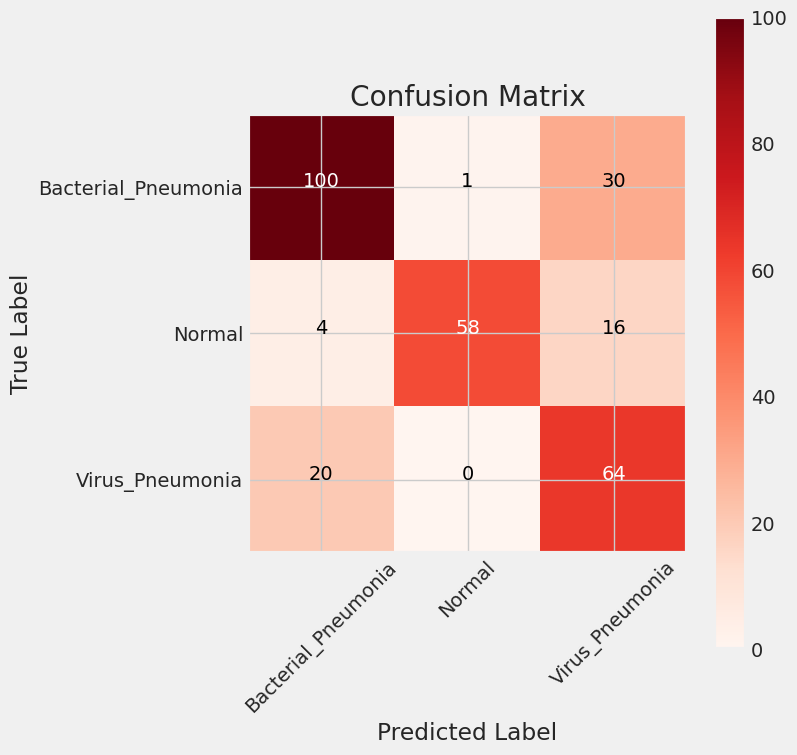

              precision    recall  f1-score   support

           0       0.81      0.76      0.78       131
           1       0.98      0.74      0.85        78
           2       0.58      0.76      0.66        84

    accuracy                           0.76       293
   macro avg       0.79      0.76      0.76       293
weighted avg       0.79      0.76      0.77       293



In [ ]:
# get predictions
y_pred = get_pred(cnn_model, test_gen)

# plot the confusion matrix
plot_confusion_matrix(test_gen, y_pred, fold + 1)

# #accuracy
# accuracy = accuracy_score(test_gen.classes, y_pred)
# print(f"Accuracy for fold {fold + 1}: {accuracy: .4f}")


#Recall
print(classification_report(test_gen.classes, y_pred))

In [ ]:
model_path = 'chest-xray.h5'

In [ ]:
cnn_model.save(model_path)

In [ ]:
#########################################################################

In [3]:
# Import system libs
import os
import itertools

# Import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from zoopt import Dimension, Objective, Parameter, Opt
import tensorflow.keras.backend as K
from imblearn.under_sampling import TomekLinks  # <-- Corrected import for TomekLinks
from imblearn.over_sampling import SMOTE
import cv2
sns.set_style('darkgrid')


In [4]:
# Enable GPU memory growth to avoid full memory allocation upfront
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

# Define the strategy for distributed training (if multiple GPUs are available)
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


I0000 00:00:1727320472.671788 2271093 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727320472.704741 2271093 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727320472.705946 2271093 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1727320472.709063 2271093 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [5]:
# Load the dataset
def loading_the_data(data_dir):
    filepaths = []
    labels = []
    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis=1)
    return df

In [6]:
def change_label_names(df, column_name):
    index = {'milddemented': 'MildDemented', 
             'Alzheimer NonDemented': 'Alzheimer_Nondemented', 
             'very_milddemented': 'Alzheimer VeryMildDemented'}
    df[column_name] = df[column_name].replace(index)

data_dir = '/home/idrone2/Desktop/alzheimer'
df = loading_the_data(data_dir)
change_label_names(df, 'labels')

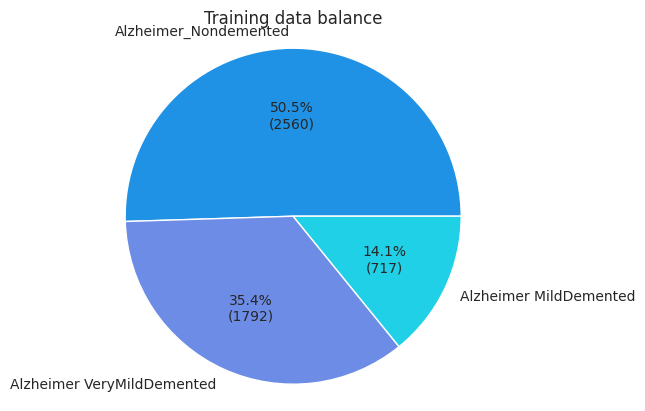

In [7]:
# Data balance pie chart
data_balance = df.labels.value_counts()
def custom_autopct(pct):
    total = sum(data_balance)
    val = int(round(pct*total/100.0))
    return "{:.1f}%\n({:d})".format(pct, val)
plt.pie(data_balance, labels=data_balance.index, autopct=custom_autopct, colors=["#2092E6", "#6D8CE6", "#20D0E6"])
plt.title("Training data balance")
plt.axis("equal")
plt.show()

In [8]:
def load_and_preprocess_image(image_path, img_size=(224, 224)):
    # Load the image from the file path
    img = cv2.imread(image_path)
    # Resize the image to a fixed size
    img_resized = cv2.resize(img, img_size)
    # Flatten the image to a 1D vector
    img_flattened = img_resized.flatten()
    return img_flattened

In [9]:
df = loading_the_data(data_dir)
change_label_names(df, 'labels')

# Check the structure of the DataFrame to make sure 'filepaths' exists
print(df.head())  #

                                           filepaths                 labels
0  /home/idrone2/Desktop/alzheimer/Alzheimer NonD...  Alzheimer_Nondemented
1  /home/idrone2/Desktop/alzheimer/Alzheimer NonD...  Alzheimer_Nondemented
2  /home/idrone2/Desktop/alzheimer/Alzheimer NonD...  Alzheimer_Nondemented
3  /home/idrone2/Desktop/alzheimer/Alzheimer NonD...  Alzheimer_Nondemented
4  /home/idrone2/Desktop/alzheimer/Alzheimer NonD...  Alzheimer_Nondemented


In [10]:
# Adjust the balance_data function to retain 'filepaths' for later use
def balance_data(df):
    # Use labels for balancing but retain the filepaths
    filepaths = df['filepaths']
    labels = df['labels']
    
    # Convert filepaths to numerical indices temporarily (because SMOTE needs numerical data)
    X = np.arange(len(filepaths)).reshape(-1, 1)

    # Apply SMOTE and Tomek Links for label balancing
    smote = SMOTE()
    tomek = TomekLinks()

    # Resample based on the labels
    X_resampled, y_resampled = smote.fit_resample(X, labels)
    X_resampled, y_resampled = tomek.fit_resample(X_resampled, y_resampled)

    # Use the resampled indices to get the corresponding filepaths
    filepaths_resampled = filepaths.iloc[X_resampled.flatten()].values

    # Return a DataFrame with resampled filepaths and labels
    balanced_df = pd.DataFrame({'filepaths': filepaths_resampled, 'labels': y_resampled})
    return balanced_df

# Apply the updated balance_data function to balance the dataset
df = balance_data(df)

# The rest of your code remains the same


In [11]:
# Custom Dice Loss
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)  # Correct function call from tf.keras.backend
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


In [12]:
# Custom Jaccard Loss
def jaccard_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)  # Correct function call from tf.keras.backend
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(K.abs(y_true_f * y_pred_f))
    sum_ = K.sum(K.abs(y_true_f) + K.abs(y_pred_f))
    jac = (intersection + 1e-7) / (sum_ - intersection + 1e-7)
    return (1 - jac)

In [13]:
# K-fold cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
batch_size = 32
img_size = (224, 224)
tr_gen = ImageDataGenerator(rescale=1. / 255)
ts_gen = ImageDataGenerator(rescale=1. / 255)


In [14]:
# CNN model creation function with custom loss
def create_cnn_model(filters1, filters2, filters3, units1, units2, learning_rate, loss):
    img_shape = (224, 224, 3)
    cnn_model = Sequential()
    cnn_model.add(Conv2D(filters=int(filters1), kernel_size=(3, 3), padding="same", activation="relu", input_shape=img_shape))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPooling2D())
    cnn_model.add(Conv2D(filters=int(filters2), kernel_size=(3, 3), padding="same", activation="relu"))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPooling2D())
    cnn_model.add(Conv2D(filters=int(filters3), kernel_size=(3, 3), padding="same", activation="relu"))
    cnn_model.add(BatchNormalization())
    cnn_model.add(MaxPooling2D())
    cnn_model.add(Flatten())
    cnn_model.add(Dense(units=int(units1), activation='relu'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Dropout(0.5))
    cnn_model.add(Dense(units=int(units2), activation='relu'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Dropout(0.3))
    cnn_model.add(Dense(len(df['labels'].unique()), activation="softmax"))
    optimizer = Adam(learning_rate=learning_rate)
    cnn_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return cnn_model

In [15]:
def objective_function_with_loss(solution, loss):
    filters1, filters2, filters3, units1, units2, learning_rate = solution.get_x()
    accuracies = []
    
    for train_index, val_index in kf.split(df):
        # Use the balanced DataFrame
        train_df = df.iloc[train_index]
        val_df = df.iloc[val_index]
        
        # Use the filepaths column to load images in real-time
        train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                               color_mode='rgb', shuffle=True, batch_size=batch_size)
        val_gen = ts_gen.flow_from_dataframe(val_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                             color_mode='rgb', shuffle=True, batch_size=batch_size)
        
        # Create and train the CNN model
        model = create_cnn_model(filters1, filters2, filters3, units1, units2, learning_rate, loss)
        model.fit(train_gen, validation_data=val_gen, epochs=20, verbose=0)
        
        # Evaluate the model on the validation set
        val_loss, val_acc = model.evaluate(val_gen, verbose=0)
        accuracies.append(val_acc)
    
    # Return the negative mean accuracy as the objective value to minimize
    return -np.mean(accuracies)

In [16]:
print(df.columns)
print(df.head())

Index(['filepaths', 'labels'], dtype='object')
                                           filepaths                 labels
0  /home/idrone2/Desktop/alzheimer/Alzheimer NonD...  Alzheimer_Nondemented
1  /home/idrone2/Desktop/alzheimer/Alzheimer NonD...  Alzheimer_Nondemented
2  /home/idrone2/Desktop/alzheimer/Alzheimer NonD...  Alzheimer_Nondemented
3  /home/idrone2/Desktop/alzheimer/Alzheimer NonD...  Alzheimer_Nondemented
4  /home/idrone2/Desktop/alzheimer/Alzheimer NonD...  Alzheimer_Nondemented


In [17]:
# Check if 'filepaths' column exists
if 'filepaths' not in df.columns:
    print("Error: 'filepaths' column not found!")

df.rename(columns={'image_paths': 'filepaths'}, inplace=True)


In [18]:
# Define ZOOpt dimension and parameters
dim = Dimension(6, 
                [[16, 64], 
                 [32, 128], 
                 [64, 256], 
                 [64, 512], 
                 [32, 256], 
                 [1e-5, 1e-3]], 
                 [False, False, False, False, False, True])

param = Parameter(budget=20)


# Optimize using Dice Loss and Jaccard Loss
dice_obj = Objective(lambda sol: objective_function_with_loss(sol, dice_loss), dim)
jaccard_obj = Objective(lambda sol: objective_function_with_loss(sol, jaccard_loss), dim)

dice_solution = Opt.min(dice_obj, param)
jaccard_solution = Opt.min(jaccard_obj, param)

print(f"Best Dice Hyperparameters: {dice_solution.get_x()}")
print(f"Best Jaccard Hyperparameters: {jaccard_solution.get_x()}")

Found 6144 validated image filenames belonging to 3 classes.
Found 1536 validated image filenames belonging to 3 classes.


/home/idrone2/.local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/idrone2/.local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1727320499.540234 2271541 service.cc:146] XLA service 0x7252a4005210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727320499.540252 2271541 service.cc:154]   StreamExecutor device (0): NVIDIA RTX 

Found 6144 validated image filenames belonging to 3 classes.
Found 1536 validated image filenames belonging to 3 classes.


/home/idrone2/.local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/idrone2/.local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 6144 validated image filenames belonging to 3 classes.
Found 1536 validated image filenames belonging to 3 classes.


/home/idrone2/.local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/idrone2/.local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 6144 validated image filenames belonging to 3 classes.
Found 1536 validated image filenames belonging to 3 classes.


/home/idrone2/.local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/idrone2/.local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 6144 validated image filenames belonging to 3 classes.
Found 1536 validated image filenames belonging to 3 classes.


/home/idrone2/.local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/idrone2/.local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 6144 validated image filenames belonging to 3 classes.
Found 1536 validated image filenames belonging to 3 classes.


/home/idrone2/.local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/idrone2/.local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 6144 validated image filenames belonging to 3 classes.
Found 1536 validated image filenames belonging to 3 classes.


/home/idrone2/.local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/idrone2/.local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 6144 validated image filenames belonging to 3 classes.
Found 1536 validated image filenames belonging to 3 classes.


/home/idrone2/.local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/idrone2/.local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 6144 validated image filenames belonging to 3 classes.
Found 1536 validated image filenames belonging to 3 classes.


/home/idrone2/.local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/idrone2/.local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 6144 validated image filenames belonging to 3 classes.
Found 1536 validated image filenames belonging to 3 classes.


/home/idrone2/.local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/idrone2/.local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 6144 validated image filenames belonging to 3 classes.
Found 1536 validated image filenames belonging to 3 classes.


/home/idrone2/.local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/idrone2/.local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 6144 validated image filenames belonging to 3 classes.
Found 1536 validated image filenames belonging to 3 classes.


/home/idrone2/.local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/idrone2/.local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 6144 validated image filenames belonging to 3 classes.
Found 1536 validated image filenames belonging to 3 classes.


/home/idrone2/.local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/idrone2/.local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 6144 validated image filenames belonging to 3 classes.
Found 1536 validated image filenames belonging to 3 classes.


/home/idrone2/.local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/idrone2/.local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 6144 validated image filenames belonging to 3 classes.
Found 1536 validated image filenames belonging to 3 classes.


/home/idrone2/.local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/idrone2/.local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Found 6144 validated image filenames belonging to 3 classes.
Found 1536 validated image filenames belonging to 3 classes.


/home/idrone2/.local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/idrone2/.local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-09-26 09:54:26.363502: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be p

ResourceExhaustedError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/idrone2/.local/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/idrone2/.local/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/idrone2/.local/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/idrone2/.local/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/home/idrone2/.local/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/idrone2/.local/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/idrone2/.local/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/idrone2/.local/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/idrone2/.local/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/idrone2/.local/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/idrone2/.local/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/idrone2/.local/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/idrone2/.local/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/idrone2/.local/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/idrone2/.local/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/idrone2/.local/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/idrone2/.local/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_2271093/399611248.py", line 18, in <module>

  File "/home/idrone2/.local/lib/python3.11/site-packages/zoopt/opt.py", line 50, in min

  File "/home/idrone2/.local/lib/python3.11/site-packages/zoopt/algos/opt_algorithms/racos/racos_optimization.py", line 57, in opt

  File "/home/idrone2/.local/lib/python3.11/site-packages/zoopt/algos/opt_algorithms/racos/sracos.py", line 47, in opt

  File "/home/idrone2/.local/lib/python3.11/site-packages/zoopt/algos/opt_algorithms/racos/racos_common.py", line 92, in init_attribute

  File "/home/idrone2/.local/lib/python3.11/site-packages/zoopt/objective.py", line 83, in eval

  File "/tmp/ipykernel_2271093/399611248.py", line 15, in <lambda>

  File "/tmp/ipykernel_2271093/4144709158.py", line 18, in objective_function_with_loss

  File "/home/idrone2/.local/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/idrone2/.local/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/home/idrone2/.local/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

Out of memory while trying to allocate 1125734312 bytes.
	 [[{{node StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_233070]

In [ ]:
# Class Activation Maps (CAM)
def generate_cam(model, img_array):
    final_conv_layer = model.get_layer('conv2d')
    grads = K.gradients(model.output, final_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, final_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([img_array])
    for i in range(pooled_grads_value.shape[-1]):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap


In [ ]:
# Plot graphical abstract with results
def plot_graphical_abstract(history, y_pred, test_gen, cam_imgs, class_names):
    model_performance(history, Epochs)
    plot_confusion_matrix(test_gen, y_pred)
    for cam_img, class_name in zip(cam_imgs, class_names):
        plt.imshow(cam_img)
        plt.title(f"Class Activation Map for {class_name}")
        plt.show()


In [ ]:
# Helper function to plot model performance
def model_performance(history, Epochs):
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    Epochs = [i+1 for i in range(len(tr_acc))]
    plt.plot(Epochs, tr_acc, 'g', label="Training Accuracy")
    plt.plot(Epochs, val_acc, 'r', label="Validation Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    plt.plot(Epochs, tr_loss, 'g', label="Training Loss")
    plt.plot(Epochs, val_loss, 'r', label="Validation Loss")
    plt.title("Training & Validation Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [ ]:
# Helper function to plot confusion matrix
def plot_confusion_matrix(test_gen, y_pred):
    y_true = test_gen.classes
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices, yticklabels=test_gen.class_indices)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()
